In [37]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

# Load Datasets

In [143]:
playlist = pd.read_parquet("../phase2_data_cleaning/cleaned dataset/playlist_cleaned.parquet", columns=["playlist_idx", "tracks"])
playlist_recco = pd.read_parquet("../phase3_feature_engineering/feature engineered datasets/playlist.parquet", columns=["playlist_idx", "name_embeddings", "track_idx_list", "popularity_mean",
                                                                                                                        "early_years_proportion", "classic_era_proportion", "golden_era_proportion",
                                                                                                                        "2000s_proportion", "modern_era_proportion", "short_proportion",
                                                                                                                        "medium_proportion", "long_proportion"])
track = pd.read_parquet("../phase2_data_cleaning/cleaned dataset/track_cleaned.parquet", columns=["track_idx", "track_uri"])

# Select the first 1000 playlists

In [144]:
playlist_selected = playlist.head(1000)
playlist_recco = playlist_recco.head(1000)

# Select the unique tracks in the 1000 playlists

In [145]:
# Extract unique values from the 'tracks' column
unique_values = set()

# Iterate over the rows in the 'tracks' column
for track_str in playlist_selected["tracks"]:
    # Convert the string representation to a dictionary
    track_dict = ast.literal_eval(track_str)
    
    if isinstance(track_dict, dict):  # Ensure it's a dictionary
        # Add integer values to the set
        unique_values.update(int(value) for value in track_dict.values())

# Convert to DataFrame with 'track_idx' as integers
unique_df = pd.DataFrame(unique_values, columns=["track_idx"])
unique_df = unique_df.sort_values(by="track_idx", ascending=True).reset_index(drop=True)

# Display the DataFrame
print(unique_df)

       track_idx
0              1
1              5
2             15
3             36
4             38
...          ...
37437     252207
37438     252209
37439     252210
37440     252213
37441     252216

[37442 rows x 1 columns]


# Merge with the `track_uri` in the Track dataset

In [146]:
# Extract the unique 'track_idx' from the unique_df
unique_track_idx = unique_df['track_idx']

# Filter the 'track' DataFrame based on whether 'track_idx' is in the unique values
filtered_track = track[track['track_idx'].isin(unique_track_idx)]

# Display the filtered DataFrame
print(filtered_track)

        track_idx                             track_uri
1               1  spotify:track:000GjfnQc7ggBayDiy1sLW
5               5  spotify:track:000xQL6tZNLJzIrtIgxqSl
15             15  spotify:track:002opcRBgYV5jqoh72QcqA
36             36  spotify:track:005X0FmdtkM1kiutosXLTR
38             38  spotify:track:005drRcJJFgFHgtxSJJO0v
...           ...                                   ...
252207     252207  spotify:track:7zwtlwZslYsynnoDxH7lOR
252209     252209  spotify:track:7zx34MQjW5Svvltow5EzsR
252210     252210  spotify:track:7zx5GJLsFcKpXfvFAIioqI
252213     252213  spotify:track:7zxRMhXxJMQCeDDg0rKAVo
252216     252216  spotify:track:7zxhhMt0j1JV7OuFpQ2Boe

[37442 rows x 2 columns]


# Save files

In [147]:
playlist_selected = playlist_selected.drop(columns=['tracks'])
playlist_selected.to_parquet("datasets/1000_playlist_idx_only.parquet", index=False)
filtered_track.to_parquet("datasets/1000_track_idx_only.parquet", index=False)

# Create Track Table using Sample

### Load Relevant Datasets

In [148]:
pop_era_duration_artist_idx = pd.read_parquet("../phase2_data_cleaning/cleaned dataset/track_cleaned.parquet", columns=["track_idx","artist_idx", "album_idx", "era", "category", "track_popularity"])
sentiment = pd.read_parquet("../phase3_feature_engineering/scores/sentiment_scores_1000_subsample.parquet")
genre = pd.read_parquet("../phase3_feature_engineering/scores/genre_scores.parquet")

### Merge `Popularity`, `Era`, `Duration` first

In [149]:
# Perform the merge on 'track_idx'
track_final = pd.merge(filtered_track, pop_era_duration_artist_idx, on='track_idx', how='inner')

# Display the merged DataFrame
track_final.head()

,track_idx,track_uri,artist_idx,album_idx,era,category,track_popularity
0,1,spotify:track:000GjfnQc7ggBayDiy1sLW,26382,19030,2000s,Short,18
1,5,spotify:track:000xQL6tZNLJzIrtIgxqSl,38821,45744,Modern Era,Medium,54
2,15,spotify:track:002opcRBgYV5jqoh72QcqA,19124,116350,Modern Era,Medium,37
3,36,spotify:track:005X0FmdtkM1kiutosXLTR,35662,88581,Classic Era,Short,6
4,38,spotify:track:005drRcJJFgFHgtxSJJO0v,43820,63597,Modern Era,Long,44


### Merge Sentiment Scores

In [150]:
track_final = pd.merge(track_final, sentiment, on='track_idx', how='left')
track_final.head()

,track_idx,track_uri,artist_idx,album_idx,era,category,track_popularity,joy,calm,sadness,fear,energizing,dreamy
0,1,spotify:track:000GjfnQc7ggBayDiy1sLW,26382,19030,2000s,Short,18,NaN,NaN,NaN,NaN,NaN,NaN
1,5,spotify:track:000xQL6tZNLJzIrtIgxqSl,38821,45744,Modern Era,Medium,54,0.152113,0.155419,0.106975,0.201760,0.196968,0.186765
2,15,spotify:track:002opcRBgYV5jqoh72QcqA,19124,116350,Modern Era,Medium,37,0.162265,0.030118,0.002151,0.008668,0.429312,0.367487
3,36,spotify:track:005X0FmdtkM1kiutosXLTR,35662,88581,Classic Era,Short,6,0.293550,0.115370,0.001115,0.002680,0.295220,0.292065
4,38,spotify:track:005drRcJJFgFHgtxSJJO0v,43820,63597,Modern Era,Long,44,0.005309,0.018578,0.306113,0.346907,0.195283,0.127809


### Merge Genre Scores

In [151]:
track_final = pd.merge(track_final, genre, on='track_uri', how='left')
track_final.head()

,track_idx,track_uri,artist_idx,album_idx,era,category,track_popularity,joy,calm,sadness,...,energizing,dreamy,Instrumental / Ambient Sounds,Soft Acoustic / Classical,Orchestral / Soundtrack,Mid-tempo Pop / Indie,Upbeat Electronic / Dance,Slow & Melancholic (Sad Songs),Experimental / Jazz Fusion,Lo-Fi / Chill Vibes
0,1,spotify:track:000GjfnQc7ggBayDiy1sLW,26382,19030,2000s,Short,18,NaN,NaN,NaN,...,NaN,NaN,0.683467,0.005597,0.220851,0.018938,0.000612,0.062293,0.006924,0.001318
1,5,spotify:track:000xQL6tZNLJzIrtIgxqSl,38821,45744,Modern Era,Medium,54,0.152113,0.155419,0.106975,...,0.196968,0.186765,0.012407,0.912539,0.010838,0.000878,0.047247,0.004436,0.002915,0.008741
2,15,spotify:track:002opcRBgYV5jqoh72QcqA,19124,116350,Modern Era,Medium,37,0.162265,0.030118,0.002151,...,0.429312,0.367487,0.225427,0.017463,0.579103,0.010267,0.002024,0.150953,0.012993,0.001770
3,36,spotify:track:005X0FmdtkM1kiutosXLTR,35662,88581,Classic Era,Short,6,0.293550,0.115370,0.001115,...,0.295220,0.292065,0.012463,0.902842,0.015791,0.002660,0.022419,0.011421,0.002254,0.030149
4,38,spotify:track:005drRcJJFgFHgtxSJJO0v,43820,63597,Modern Era,Long,44,0.005309,0.018578,0.306113,...,0.195283,0.127809,0.747282,0.006214,0.120770,0.033136,0.000654,0.082782,0.007130,0.002032


### Save File

In [152]:
track_final.to_parquet("datasets/1000_track_full.parquet", index=False)

# Create Playlist Table using Track Table

### Load Relevant Datasets

In [153]:
pop_era_artist = pd.read_parquet("../phase3_feature_engineering/feature engineered datasets/playlist.parquet", 
                                 columns=["playlist_idx", "track_idx_list", "popularity_var", "artist_diversity", 
                                              "early_years_proportion", "classic_era_proportion", "golden_era_proportion", "2000s_proportion", "modern_era_proportion",
                                              "short_proportion", "medium_proportion", "long_proportion"])

### Filter to only the selected 1000 playlists

In [154]:
# Filter the track_final DataFrame based on 'playlist_idx' from playlist_selected
playlist_final = pop_era_artist[pop_era_artist['playlist_idx'].isin(playlist_selected['playlist_idx'])]

# Display the filtered DataFrame
playlist_final.head()

,playlist_idx,track_idx_list,popularity_var,artist_diversity,early_years_proportion,classic_era_proportion,golden_era_proportion,2000s_proportion,modern_era_proportion,short_proportion,medium_proportion,long_proportion
0,0,"[55709, 5427, 52495, 157555, 235367, 126542, 8...",658.67,2.128085,0.0,0.000000,0.000000,0.000000,1.000000,0.571429,0.428571,0.000000
1,1,"[3689, 207774, 194775, 135193, 218011, 37844, ...",834.42,5.136249,0.0,0.000000,0.000000,0.000000,1.000000,0.095238,0.714286,0.190476
2,2,"[160375, 131195, 164629, 147280, 193891, 17077...",300.85,4.321928,0.0,0.450000,0.200000,0.200000,0.150000,0.200000,0.350000,0.450000
3,3,"[104436, 229428, 25968, 186871, 81592, 15947, ...",776.50,5.760648,0.0,0.209677,0.467742,0.290323,0.032258,0.241935,0.516129,0.241935
4,4,"[244173, 210510, 9349, 224202, 147251, 35498, ...",365.06,5.004921,0.0,0.000000,0.000000,0.067568,0.932432,0.000000,0.324324,0.675676


### Duration Diversity

In [155]:
def shannon_entropy(row):
    # Convert proportions to a NumPy array from the separate columns
    proportions = np.array([row["short_proportion"], row["medium_proportion"], row["long_proportion"]])
    
    # Mask the zero values (replace them with a small value)
    proportions = np.where(proportions == 0, np.finfo(float).eps, proportions)
    
    # Calculate entropy: -sum(p(x) * log2(p(x)))
    entropy = -np.sum(proportions * np.log2(proportions))
        
    return entropy

# Apply the Shannon entropy function to each row
playlist_final.loc[:, 'duration_var'] = playlist_final.apply(shannon_entropy, axis=1)
playlist_final = playlist_final.drop(columns=['short_proportion', 'medium_proportion', 'long_proportion'])

/var/folders/xf/v125knts0p57cdp0hhtgh8y00000gn/T/ipykernel_92141/2070016791.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlist_final.loc[:, 'duration_var'] = playlist_final.apply(shannon_entropy, axis=1)


### Era Diversity

In [156]:
def shannon_entropy(row):
    # Convert proportions to a NumPy array from the separate columns
    proportions = np.array([row["early_years_proportion"], row["classic_era_proportion"], row["golden_era_proportion"], row["2000s_proportion"], row["modern_era_proportion"]])
    
    # Mask the zero values (replace them with a small value)
    proportions = np.where(proportions == 0, np.finfo(float).eps, proportions)
    
    # Calculate entropy: -sum(p(x) * log2(p(x)))
    entropy = -np.sum(proportions * np.log2(proportions))
        
    return entropy

# Apply the Shannon entropy function to each row
playlist_final.loc[:, 'era_var'] = playlist_final.apply(shannon_entropy, axis=1)
playlist_final = playlist_final.drop(columns=["early_years_proportion", "classic_era_proportion", "golden_era_proportion", "2000s_proportion", "modern_era_proportion"])

### Genre Diversity

In [157]:
track_audio = track_final[['track_idx', "Instrumental / Ambient Sounds", "Soft Acoustic / Classical", "Orchestral / Soundtrack","Mid-tempo Pop / Indie","Upbeat Electronic / Dance",
                           "Slow & Melancholic (Sad Songs)", "Experimental / Jazz Fusion", "Lo-Fi / Chill Vibes"]]
track_audio.head()

,track_idx,Instrumental / Ambient Sounds,Soft Acoustic / Classical,Orchestral / Soundtrack,Mid-tempo Pop / Indie,Upbeat Electronic / Dance,Slow & Melancholic (Sad Songs),Experimental / Jazz Fusion,Lo-Fi / Chill Vibes
0,1,0.683467,0.005597,0.220851,0.018938,0.000612,0.062293,0.006924,0.001318
1,5,0.012407,0.912539,0.010838,0.000878,0.047247,0.004436,0.002915,0.008741
2,15,0.225427,0.017463,0.579103,0.010267,0.002024,0.150953,0.012993,0.001770
3,36,0.012463,0.902842,0.015791,0.002660,0.022419,0.011421,0.002254,0.030149
4,38,0.747282,0.006214,0.120770,0.033136,0.000654,0.082782,0.007130,0.002032


Impute Missing Values (NOT NEEDED FOR THE FINAL VERSION)

In [158]:
# Define the DataFrame (assuming track_audio is already loaded)
columns_to_impute = [
    "Instrumental / Ambient Sounds", "Soft Acoustic / Classical", "Orchestral / Soundtrack",
    "Mid-tempo Pop / Indie", "Upbeat Electronic / Dance", "Slow & Melancholic (Sad Songs)",
    "Experimental / Jazz Fusion", "Lo-Fi / Chill Vibes"
]

# Impute missing values with the median for each column
track_audio.loc[:, columns_to_impute] = track_audio[columns_to_impute].fillna(track_audio[columns_to_impute].median())

# Normalize so that each row sums to 1
row_sums = track_audio[columns_to_impute].sum(axis=1)

# Avoid division by zero, normalize, then replace NaNs with 0 (if a row was entirely 0)
track_audio.loc[:, columns_to_impute] = track_audio[columns_to_impute].div(row_sums, axis=0).fillna(0)

Temporary

In [159]:
track_final = track_final.drop(columns=columns_to_impute)
track_final = pd.merge(track_final, track_audio, on='track_idx', how='inner')

**Version 1: Find Cosine Similarity to the Centroid Vector**


Higher score means higher diversity <br><br>
Lower score means lower divesity

In [160]:
# Define the feature categories (for consistency with your approach)
FEATURE_COLUMNS = [
    "Instrumental / Ambient Sounds", "Soft Acoustic / Classical", "Orchestral / Soundtrack",
    "Mid-tempo Pop / Indie", "Upbeat Electronic / Dance", "Slow & Melancholic (Sad Songs)",
    "Experimental / Jazz Fusion", "Lo-Fi / Chill Vibes"
]

# Prepare result storage
results = []

# Assuming track_audio is a DataFrame with track_idx and audio feature columns
# Convert track_audio DataFrame to dictionary mapping track_idx to audio features
track_audio_dict = {str(track_audio['track_idx'].iloc[i]): track_audio.iloc[i, 1:].values for i in range(len(track_audio))}

# Store centroids in a separate list for playlist_recco
playlist_centroids = []

# Iterate through each playlist in playlist_final
for _, row in playlist_final.iterrows():
    playlist_idx = row['playlist_idx']

    # Ensure track_idx_list is a list of track ids
    if isinstance(row['track_idx_list'], (list, np.ndarray)):
        track_ids = [str(idx).strip() for idx in row['track_idx_list']]
    else:
        print(f"Skipping Playlist {playlist_idx}: track_idx_list format not recognized.")
        continue

    # Convert track_idx to integer and filter None values
    track_ids_int = [int(idx) for idx in track_ids]
    
    # Extract audio feature vectors for tracks in the playlist (skip None values)
    playlist_vectors = np.array([track_audio_dict.get(str(idx)) for idx in track_ids_int if track_audio_dict.get(str(idx)) is not None])

    # Skip if no valid vectors found
    if playlist_vectors.size == 0:
        print(f"Skipping Playlist {playlist_idx} (No valid vectors found)")
        continue  

    # Compute the centroid (mean vector across audio feature space)
    centroid = np.mean(playlist_vectors, axis=0)

    # Store the centroid for playlist_recco
    playlist_centroids.append({
        'playlist_idx': playlist_idx,
        'genre_centroid': centroid
    })

    # Handle single-track playlists (assign perfect dissimilarity)
    if len(playlist_vectors) == 1:
        cos_similarities = np.array([1.0])  # Cosine similarity with itself is 1
    else:
        cos_similarities = cosine_similarity(playlist_vectors, centroid.reshape(1, -1)).flatten()

    # Store results (store 1 - similarity score for diversity interpretation)
    for i, track_id in enumerate(track_ids_int):
        results.append({
            'playlist_idx': playlist_idx,
            'track_idx': track_id,
            'diversity_score': float(1 - cos_similarities[i]),  # 1 - cosine similarity for diversity
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Rename columns to lowercase with underscores instead of spaces
results_df.columns = [col.replace(' ', '_').lower() for col in results_df.columns]

# Group by playlist_idx and calculate the average diversity_score
playlist_genre_avg_similarity = results_df.groupby('playlist_idx')['diversity_score'].mean().reset_index()

# Rename the column to indicate it's the average diversity score
playlist_genre_avg_similarity.columns = ['playlist_idx', 'avg_diversity_score']

# Output the result
print(playlist_genre_avg_similarity.head())

playlist_centroids_df = pd.DataFrame(playlist_centroids)
playlist_recco = pd.merge(playlist_recco, playlist_centroids_df, on='playlist_idx', how='left')

   playlist_idx  avg_diversity_score
0             0             0.355083
1             1             0.448292
2             2             0.383259
3             3             0.420412
4             4             0.456590


**Version 2: Find Euclidean Distance to the Centroid Vector**

Higher score means higher diversity <br><br>
Lower score means lower divesity

In [161]:
# Define the feature categories (for consistency with your approach)
FEATURE_COLUMNS = [
    "Instrumental / Ambient Sounds", "Soft Acoustic / Classical", "Orchestral / Soundtrack",
    "Mid-tempo Pop / Indie", "Upbeat Electronic / Dance", "Slow & Melancholic (Sad Songs)",
    "Experimental / Jazz Fusion", "Lo-Fi / Chill Vibes"
]

# Prepare result storage
results = []

# Assuming track_audio is a DataFrame with track_idx and audio feature columns
# Convert track_audio DataFrame to dictionary mapping track_idx to audio features
track_audio_dict = {str(track_audio['track_idx'].iloc[i]): track_audio.iloc[i, 1:].values for i in range(len(track_audio))}

# Iterate through each playlist in playlist_final
for _, row in playlist_final.iterrows():
    playlist_idx = row['playlist_idx']

    # Ensure track_idx_list is a list of track ids
    if isinstance(row['track_idx_list'], (list, np.ndarray)):
        track_ids = [str(idx).strip() for idx in row['track_idx_list']]
    else:
        print(f"Skipping Playlist {playlist_idx}: track_idx_list format not recognized.")
        continue

    # Convert track_idx to integer and filter None values
    track_ids_int = [int(idx) for idx in track_ids]
    
    # Extract audio feature vectors for tracks in the playlist (skip None values)
    playlist_vectors = np.array([track_audio_dict.get(str(idx)) for idx in track_ids_int if track_audio_dict.get(str(idx)) is not None])

    # Skip if no valid vectors found
    if playlist_vectors.size == 0:
        print(f"Skipping Playlist {playlist_idx} (No valid vectors found)")
        continue  

    # Compute the centroid (mean vector across audio feature space)
    centroid = np.mean(playlist_vectors, axis=0)

    # Calculate Euclidean distance from each track vector to the centroid
    for i, track_id in enumerate(track_ids_int):
        vector = playlist_vectors[i]
        distance = np.linalg.norm(vector - centroid)  # Euclidean distance

        results.append({
            'playlist_idx': playlist_idx,
            'track_idx': track_id,
            'diversity_score': float(distance),  # Higher distance → more diverse
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Rename columns to lowercase with underscores instead of spaces
results_df.columns = [col.replace(' ', '_').lower() for col in results_df.columns]

# Group by playlist_idx and calculate the average diversity_score
playlist_genre_avg_distance = results_df.groupby('playlist_idx')['diversity_score'].mean().reset_index()

# Rename the column to indicate it's the average diversity score
playlist_genre_avg_distance.columns = ['playlist_idx', 'avg_diversity_score']

# Output the result
print(playlist_genre_avg_distance.head())

   playlist_idx  avg_diversity_score
0             0             0.578384
1             1             0.653367
2             2             0.598667
3             3             0.618326
4             4             0.656274


Compare whether there is a significant difference in the 2 versions

Spearman Correlation: 0.9168 (p-value: 0.0000)
Pearson Correlation: 0.9168 (p-value: 0.0000)


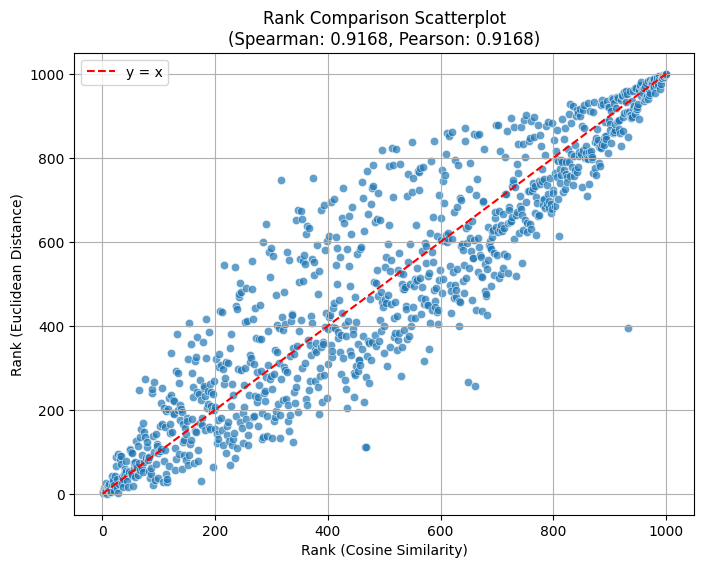

In [162]:
# Merge the two DataFrames on 'playlist_idx'
comparison_df = playlist_genre_avg_similarity.merge(
    playlist_genre_avg_distance, on='playlist_idx', suffixes=('_cosine', '_euclidean')
)

# Sort by both metrics to compare rankings
comparison_df = comparison_df.sort_values(by='avg_diversity_score_cosine', ascending=False)

# Assign ranks based on both metrics
comparison_df['rank_cosine'] = comparison_df['avg_diversity_score_cosine'].rank(ascending=False)
comparison_df['rank_euclidean'] = comparison_df['avg_diversity_score_euclidean'].rank(ascending=False)

# Compute Spearman correlation (for ranked data)
spearman_corr, spearman_pval = spearmanr(comparison_df['rank_cosine'], comparison_df['rank_euclidean'])

# Compute Pearson correlation (for linear relationship)
pearson_corr, pearson_pval = pearsonr(comparison_df['rank_cosine'], comparison_df['rank_euclidean'])

# Print correlation results
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_pval:.4f})")
print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_pval:.4f})")

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=comparison_df['rank_cosine'], y=comparison_df['rank_euclidean'], alpha=0.7)

# Plot identity line (y = x) for reference
plt.plot([comparison_df['rank_cosine'].min(), comparison_df['rank_cosine'].max()], 
         [comparison_df['rank_cosine'].min(), comparison_df['rank_cosine'].max()], 
         linestyle='dashed', color='red', label='y = x')

# Labels and title
plt.xlabel('Rank (Cosine Similarity)')
plt.ylabel('Rank (Euclidean Distance)')
plt.title(f"Rank Comparison Scatterplot\n(Spearman: {spearman_corr:.4f}, Pearson: {pearson_corr:.4f})")
plt.legend()
plt.grid(True)
plt.show()

This shows that it is fine to use either version 1 or version 2.

### Sentiment Diversity 

In [163]:
track_sentiment = track_final[['track_idx', 'album_idx', 'artist_idx', "joy", "calm", "sadness", "fear", "energizing", "dreamy"]]
track_sentiment.head()

,track_idx,album_idx,artist_idx,joy,calm,sadness,fear,energizing,dreamy
0,1,19030,26382,NaN,NaN,NaN,NaN,NaN,NaN
1,5,45744,38821,0.152113,0.155419,0.106975,0.201760,0.196968,0.186765
2,15,116350,19124,0.162265,0.030118,0.002151,0.008668,0.429312,0.367487
3,36,88581,35662,0.293550,0.115370,0.001115,0.002680,0.295220,0.292065
4,38,63597,43820,0.005309,0.018578,0.306113,0.346907,0.195283,0.127809


Impute Missing Data (NEEDED FOR FINAL ONE)

In [164]:
# Define columns to impute
sentiment_columns = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

# Step 1: Impute missing values using the mean of the same album
before_imputation_album = track_sentiment[sentiment_columns].isna().sum().sum()
track_sentiment.loc[:, sentiment_columns] = track_sentiment.groupby("album_idx")[sentiment_columns].transform(lambda x: x.fillna(x.mean()))
after_imputation_album = track_sentiment[sentiment_columns].isna().sum().sum()
imputed_album = before_imputation_album - after_imputation_album
print(f"Imputed {int(imputed_album / 6)} rows using the album mean.")

# Step 2: Impute missing values using the mean of the same artist (if still missing)
before_imputation_artist = track_sentiment[sentiment_columns].isna().sum().sum()
track_sentiment.loc[:, sentiment_columns] = track_sentiment.groupby("artist_idx")[sentiment_columns].transform(lambda x: x.fillna(x.mean()))
after_imputation_artist = track_sentiment[sentiment_columns].isna().sum().sum()
imputed_artist = before_imputation_artist - after_imputation_artist
print(f"Imputed {int(imputed_artist / 6)} rows using the artist mean.")

# Step 3: Impute remaining missing values using the global mean
before_imputation_global = track_sentiment[sentiment_columns].isna().sum().sum()
track_sentiment.loc[:, sentiment_columns] = track_sentiment[sentiment_columns].fillna(track_sentiment[sentiment_columns].mean())
after_imputation_global = track_sentiment[sentiment_columns].isna().sum().sum()
imputed_global = before_imputation_global - after_imputation_global
print(f"Imputed {int(imputed_global / 6)} rows using the global mean.")

# Verify if any missing values remain
remaining_missing = track_sentiment[sentiment_columns].isna().sum().sum()
print(f"Remaining missing rows: {remaining_missing}")

# Normalize the rows so that the sum of each row equals 1
track_sentiment.loc[:, sentiment_columns] = track_sentiment[sentiment_columns].div(track_sentiment[sentiment_columns].sum(axis=1), axis=0)

track_sentiment = track_sentiment.drop(columns=['artist_idx', 'album_idx'])

Imputed 939 rows using the album mean.
Imputed 1517 rows using the artist mean.
Imputed 3724 rows using the global mean.
Remaining missing rows: 0


Temporary

In [165]:
track_final = track_final.drop(columns=sentiment_columns)
track_final = pd.merge(track_final, track_sentiment, on='track_idx', how='inner')
track_final = track_final.drop(columns=['track_uri'])

**Version 1: Find Cosine Similarity to the Centroid Vector**


Higher score means higher diversity <br><br>
Lower score means lower divesity

In [166]:
# Define the sentiment columns
SENTIMENT_COLUMNS = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

# Prepare result storage
results = []

# Assuming track_sentiment is a DataFrame with track_idx and sentiment feature columns
# Convert track_sentiment DataFrame to dictionary mapping track_idx to sentiment features
track_sentiment_dict = {str(track_sentiment['track_idx'].iloc[i]): track_sentiment.iloc[i, 1:].values for i in range(len(track_sentiment))}

# Store centroids in a separate list for playlist_recco
playlist_sentiment_centroids = []

# Iterate through each playlist in playlist_final
for _, row in playlist_final.iterrows():
    playlist_idx = row['playlist_idx']

    # Ensure track_idx_list is a list of track ids
    if isinstance(row['track_idx_list'], (list, np.ndarray)):
        track_ids = [str(idx).strip() for idx in row['track_idx_list']]
    else:
        print(f"Skipping Playlist {playlist_idx}: track_idx_list format not recognized.")
        continue

    # Convert track_idx to integer and filter None values
    track_ids_int = [int(idx) for idx in track_ids]
    
    # Extract sentiment feature vectors for tracks in the playlist (skip None values)
    playlist_vectors = np.array([track_sentiment_dict.get(str(idx)) for idx in track_ids_int if track_sentiment_dict.get(str(idx)) is not None])

    # Skip if no valid vectors found
    if playlist_vectors.size == 0:
        print(f"Skipping Playlist {playlist_idx} (No valid vectors found)")
        continue  

    # Compute the centroid (mean vector across sentiment feature space)
    centroid = np.mean(playlist_vectors, axis=0)

    # Store the centroid for playlist_recco
    playlist_sentiment_centroids.append({
        'playlist_idx': playlist_idx,
        'sentiment_centroid': centroid
    })

    # Handle single-track playlists (assign perfect dissimilarity)
    if len(playlist_vectors) == 1:
        cos_similarities = np.array([1.0])  # Cosine similarity with itself is 1
    else:
        cos_similarities = cosine_similarity(playlist_vectors, centroid.reshape(1, -1)).flatten()

    # Store results (store 1 - similarity score for diversity interpretation)
    for i, track_id in enumerate(track_ids_int):
        results.append({
            'playlist_idx': playlist_idx,
            'track_idx': track_id,
            'diversity_score': float(1 - cos_similarities[i]),  # 1 - cosine similarity for diversity
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Rename columns to lowercase with underscores instead of spaces
results_df.columns = [col.replace(' ', '_').lower() for col in results_df.columns]

# Group by playlist_idx and calculate the average diversity_score
playlist_sentiment_avg_similarity = results_df.groupby('playlist_idx')['diversity_score'].mean().reset_index()

# Rename the column to indicate it's the average diversity score
playlist_sentiment_avg_similarity.columns = ['playlist_idx', 'avg_diversity_score']

# Output the result
print(playlist_sentiment_avg_similarity.head())

playlist_sentiment_centroids_df = pd.DataFrame(playlist_sentiment_centroids)
playlist_recco = pd.merge(playlist_recco, playlist_sentiment_centroids_df, on='playlist_idx', how='left')

   playlist_idx  avg_diversity_score
0             0             0.023825
1             1             0.044908
2             2             0.060603
3             3             0.091026
4             4             0.077807


**Version 2: Find Euclidean Distance to the Centroid Vector**

Higher score means higher diversity <br><br>
Lower score means lower divesity

In [167]:
# Define the sentiment columns
SENTIMENT_COLUMNS = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

# Prepare result storage
results = []

# Assuming track_sentiment is a DataFrame with track_idx and sentiment feature columns
# Convert track_sentiment DataFrame to dictionary mapping track_idx to sentiment features
track_sentiment_dict = {str(track_sentiment['track_idx'].iloc[i]): track_sentiment.iloc[i, 1:].values for i in range(len(track_sentiment))}

# Iterate through each playlist in playlist_final
for _, row in playlist_final.iterrows():
    playlist_idx = row['playlist_idx']

    # Ensure track_idx_list is a list of track ids
    if isinstance(row['track_idx_list'], (list, np.ndarray)):
        track_ids = [str(idx).strip() for idx in row['track_idx_list']]
    else:
        print(f"Skipping Playlist {playlist_idx}: track_idx_list format not recognized.")
        continue

    # Convert track_idx to integer and filter None values
    track_ids_int = [int(idx) for idx in track_ids]
    
    # Extract sentiment feature vectors for tracks in the playlist (skip None values)
    playlist_vectors = np.array([track_sentiment_dict.get(str(idx)) for idx in track_ids_int if track_sentiment_dict.get(str(idx)) is not None])

    # Skip if no valid vectors found
    if playlist_vectors.size == 0:
        print(f"Skipping Playlist {playlist_idx} (No valid vectors found)")
        continue  

    # Compute the centroid (mean vector across sentiment feature space)
    centroid = np.mean(playlist_vectors, axis=0)

    # Calculate Euclidean distance from each track vector to the centroid
    for i, track_id in enumerate(track_ids_int):
        vector = playlist_vectors[i]
        distance = np.linalg.norm(vector - centroid)  # Euclidean distance

        results.append({
            'playlist_idx': playlist_idx,
            'track_idx': track_id,
            'diversity_score': float(distance),  # Higher distance → more diverse
        })

# Convert results to a DataFrame
playlist_sentiment_avg_distance = pd.DataFrame(results)

# Rename columns to lowercase with underscores instead of spaces
playlist_sentiment_avg_distance.columns = [col.replace(' ', '_').lower() for col in playlist_sentiment_avg_distance.columns]

# Group by playlist_idx and calculate the average diversity_score
playlist_sentiment_avg_distance = playlist_sentiment_avg_distance.groupby('playlist_idx')['diversity_score'].mean().reset_index()

# Rename the column to indicate it's the average diversity score
playlist_sentiment_avg_distance.columns = ['playlist_idx', 'avg_diversity_score']

# Output the result
print(playlist_sentiment_avg_distance.head())

   playlist_idx  avg_diversity_score
0             0             0.102637
1             1             0.127156
2             2             0.152231
3             3             0.197187
4             4             0.193841


Compare whether there is a significant difference in the 2 versions

Spearman Correlation: 0.9868 (p-value: 0.0000)
Pearson Correlation: 0.9868 (p-value: 0.0000)


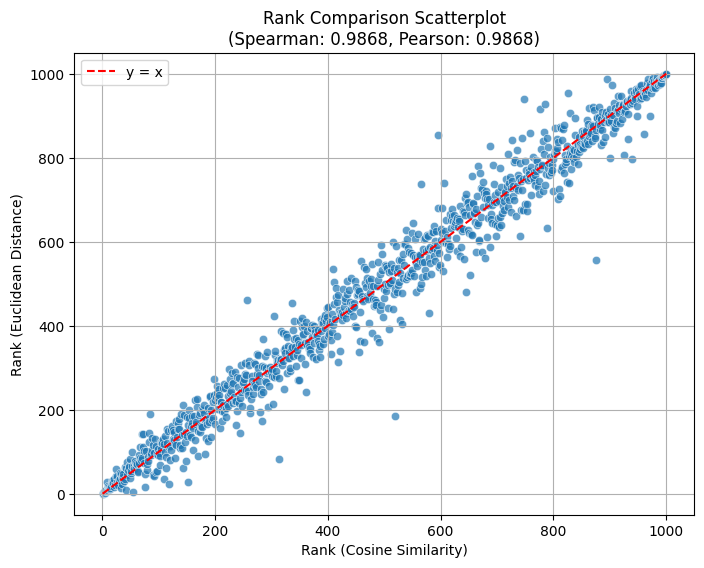

In [168]:
# Merge the two DataFrames on 'playlist_idx'
comparison_df = playlist_sentiment_avg_similarity.merge(
    playlist_sentiment_avg_distance, on='playlist_idx', suffixes=('_cosine', '_euclidean')
)

# Sort by both metrics to compare rankings
comparison_df = comparison_df.sort_values(by='avg_diversity_score_cosine', ascending=False)

# Assign ranks based on both metrics
comparison_df['rank_cosine'] = comparison_df['avg_diversity_score_cosine'].rank(ascending=False)
comparison_df['rank_euclidean'] = comparison_df['avg_diversity_score_euclidean'].rank(ascending=False)

# Compute Spearman correlation (for ranked data)
spearman_corr, spearman_pval = spearmanr(comparison_df['rank_cosine'], comparison_df['rank_euclidean'])

# Compute Pearson correlation (for linear relationship)
pearson_corr, pearson_pval = pearsonr(comparison_df['rank_cosine'], comparison_df['rank_euclidean'])

# Print correlation results
print(f"Spearman Correlation: {spearman_corr:.4f} (p-value: {spearman_pval:.4f})")
print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_pval:.4f})")

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=comparison_df['rank_cosine'], y=comparison_df['rank_euclidean'], alpha=0.7)

# Plot identity line (y = x) for reference
plt.plot([comparison_df['rank_cosine'].min(), comparison_df['rank_cosine'].max()], 
         [comparison_df['rank_cosine'].min(), comparison_df['rank_cosine'].max()], 
         linestyle='dashed', color='red', label='y = x')

# Labels and title
plt.xlabel('Rank (Cosine Similarity)')
plt.ylabel('Rank (Euclidean Distance)')
plt.title(f"Rank Comparison Scatterplot\n(Spearman: {spearman_corr:.4f}, Pearson: {pearson_corr:.4f})")
plt.legend()
plt.grid(True)
plt.show()

This shows that it is fine to use either version 1 or version 2.

# Combine Datasets

Version 1 (Using Cosine Similarity)

In [169]:
# Merge playlist_final with playlist_sentiment_avg_similarity on playlist_idx
merged_playlist_sentiment_v1 = playlist_final.merge(playlist_sentiment_avg_similarity, on='playlist_idx', how='left')

# Rename the column, e.g., 'avg_diversity_score' to 'sentiment_avg_diversity_score'
merged_playlist_sentiment_v1 = merged_playlist_sentiment_v1.rename(columns={
    'avg_diversity_score': 'sentiment_diversity'
})

# Merge the result with playlist_genre_avg_similarity on playlist_idx
playlist_for_testing_version1_cosine_similarity = merged_playlist_sentiment_v1.merge(playlist_genre_avg_similarity, on='playlist_idx', how='left')

playlist_for_testing_version1_cosine_similarity = playlist_for_testing_version1_cosine_similarity.rename(columns={
    'popularity_var': 'popularity_diversity',
    'duration_var': 'length_diversity',
    'era_var' : 'era_diversity',
    'avg_diversity_score': 'genre_diversity'
})

playlist_for_testing_version1_cosine_similarity = playlist_for_testing_version1_cosine_similarity.drop(columns=['track_idx_list'])

# Output the first few rows of the merged dataframe
playlist_for_testing_version1_cosine_similarity.head()

,playlist_idx,popularity_diversity,artist_diversity,length_diversity,era_diversity,sentiment_diversity,genre_diversity
0,0,658.67,2.128085,0.985228,4.618528e-14,0.023825,0.355083
1,1,834.42,5.136249,1.125491,4.618528e-14,0.044908,0.448292
2,2,300.85,4.321928,1.512888,1.857717e+00,0.060603,0.383259
3,3,776.50,5.760648,1.483120,1.663135e+00,0.091026,0.420412
4,4,365.06,5.004921,0.909022,3.567800e-01,0.077807,0.456590


Version 2 (Using Euclidean Distance)

In [170]:
# Merge playlist_final with playlist_sentiment_avg_similarity on playlist_idx
merged_playlist_sentiment_v2 = playlist_final.merge(playlist_sentiment_avg_distance, on='playlist_idx', how='left')

# Rename the column, e.g., 'avg_diversity_score' to 'sentiment_avg_diversity_score'
merged_playlist_sentiment_v2 = merged_playlist_sentiment_v2.rename(columns={
    'avg_diversity_score': 'sentiment_diversity'
})

# Merge the result with playlist_genre_avg_similarity on playlist_idx
playlist_for_testing_version2_euclidean_distance = merged_playlist_sentiment_v2.merge(playlist_genre_avg_distance, on='playlist_idx', how='left')

playlist_for_testing_version2_euclidean_distance = playlist_for_testing_version2_euclidean_distance.rename(columns={
    'popularity_var': 'popularity_diversity',
    'duration_var': 'length_diversity',
    'era_var' : 'era_diversity',
    'avg_diversity_score': 'genre_diversity'
})

playlist_for_testing_version2_euclidean_distance = playlist_for_testing_version2_euclidean_distance.drop(columns=['track_idx_list'])

# Output the first few rows of the merged dataframe
playlist_for_testing_version2_euclidean_distance.head()

,playlist_idx,popularity_diversity,artist_diversity,length_diversity,era_diversity,sentiment_diversity,genre_diversity
0,0,658.67,2.128085,0.985228,4.618528e-14,0.102637,0.578384
1,1,834.42,5.136249,1.125491,4.618528e-14,0.127156,0.653367
2,2,300.85,4.321928,1.512888,1.857717e+00,0.152231,0.598667
3,3,776.50,5.760648,1.483120,1.663135e+00,0.197187,0.618326
4,4,365.06,5.004921,0.909022,3.567800e-01,0.193841,0.656274


Save Datasets for Recommendation Testing

In [172]:
playlist_recco.to_parquet("for_recco_test/playlist_full.parquet", index=False)
track_final.to_parquet("for_recco_test/track_full.parquet", index=False)